In [14]:
from pathlib import Path
from collections import Counter
import os
import re
import random
import subprocess

import anndata
import scanpy as sc
import pollock
import pandas as pd
import numpy as np

import mgitools.os_helpers as os_helpers

In [20]:
CELL_TYPE_KEY = 'cell_type'
N_PER_CELL_TYPE = 200
DATA_DIR = '/home/estorrs/pollock/benchmarking/data'
RESULTS_DIR = '/home/estorrs/pollock/benchmarking/results'

Path(RESULTS_DIR).mkdir(parents=True, exist_ok=True)

##### create training and validation datasets

only run if you haven't created these datasets yet

In [15]:
def cap_list(ls, n=100, split=.8, oversample=True):
    """
    Grabs items from a pool.
    
    if split * pool size is greater than n, then just randomly sample 80% of the pool
    otherwise sample 80% of the pool, then oversample so you end up with a final size of n
    """
    cap = int(len(ls) * split)
    if cap > n:
        return random.sample(ls, n)

    if oversample:
        pool = random.sample(ls, cap)
        ## oversample to
        return random.choices(pool, k=n)

    return random.sample(ls, cap)

def balancedish_training_generator(adata, cell_type_key, n_per_cell_type, oversample=True):
    """
    Return balanced train and validation sets
    """
    cell_type_to_idxs = {}
    for cell_id, cell_type in zip(adata.obs.index, adata.obs[cell_type_key]):
        if cell_type not in cell_type_to_idxs:
            cell_type_to_idxs[cell_type] = [cell_id]
        else:
            cell_type_to_idxs[cell_type].append(cell_id)

    cell_type_to_idxs = {k:cap_list(ls, n_per_cell_type, oversample=oversample)
                         for k, ls in cell_type_to_idxs.items()}

    train_ids = np.asarray([x for ls in cell_type_to_idxs.values() for x in ls])
    train_idxs = np.arange(adata.shape[0])[np.isin(np.asarray(adata.obs.index), train_ids)]
    val_idxs = np.delete(np.arange(adata.shape[0]), train_idxs)

    train_adata = adata[train_idxs, :]
    val_adata = adata[val_idxs, :]

    return train_adata, val_adata

# def create_train_val_datasets(adata, cell_type_key, oversample=True):
#     counts = Counter(adata.obs[cell_type_key])
#     min_count = counts.most_common()[-1][1]
#     n_per_cell_type = max(min_count, )
#     train_adata, val_adata = balancedish_training_generator(adata, cell_type_key,
#                                                             n_per_cell_type, oversample=oversample)
#     return train_adata, val_adata

In [ ]:
fps = sorted(os_helpers.listfiles(DATA_DIR, regex='.h5ad$'))
fp_map = {fp.split('/')[-2]:{} for fp in fps}
for fp in fps:
    if '/_train.h5ad' not in fp and '/_val.h5ad' not in fp:
        dtype = fp.split('/')[-2]
        disease = fp.split('/')[-1].replace('.h5ad', '')
        fp_map[dtype][disease] = fp
fp_map

In [27]:
for dtype, d in fp_map.items():
    for disease, fp in d.items():
        print(dtype, disease)
        adata = sc.read_h5ad(fp)
        # check for cell type key
        if CELL_TYPE_KEY not in adata.obs: raise RuntimeError(f'{CELL_TYPE_KEY} not in {fp}')
        
        train_adata, val_adata = balancedish_training_generator(adata, CELL_TYPE_KEY, N_PER_CELL_TYPE)
        train_adata.write_h5ad(fp.replace('.h5ad', '_train.h5ad'))
        val_adata.write_h5ad(fp.replace('.h5ad', '_val.h5ad'))
        

scRNAseq cesc


/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


scRNAseq pbmc
scRNAseq pdac
snATACseq pbmc
snRNAseq gbm


##### load in training and validation datasets

In [43]:
fps = sorted(os_helpers.listfiles(DATA_DIR, regex='.h5ad$'))
adata_map = {fp.split('/')[-2]:{} for fp in fps}
for fp in fps:
    dtype = fp.split('/')[-2]
    disease = re.sub(r'^(.*)((_train)|(_val)).h5ad$', r'\1', fp.split('/')[-1])
    if disease not in adata_map[dtype] and '.h5ad' not in disease: adata_map[dtype][disease] = {}
    if 'train.h5ad' in fp:
        adata_map[dtype][disease]['train'] = sc.read_h5ad(fp)
    if 'val.h5ad' in fp:
        adata_map[dtype][disease]['val'] = sc.read_h5ad(fp)
for dtype, d in adata_map.items():
    for disease, m in d.items():
        print(dtype, disease, m['train'].shape, m['val'].shape)

scRNAseq cesc (1863, 33751) (29882, 33751)
scRNAseq pbmc (1050, 32738) (1588, 32738)
scRNAseq pdac (2940, 27160) (62201, 27160)
snATACseq pbmc (1054, 32738) (1584, 32738)
snRNAseq gbm (1330, 29032) (110649, 29032)


##### scanpy ingest

In [68]:
train, val = adata_map['scRNAseq']['pbmc']['train'].copy(), adata_map['scRNAseq']['pbmc']['val'].copy()

In [69]:
def ingest_preprocess(adata):
    adata.var['mt'] = adata.var_names.str.startswith('MT-')
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
    adata.raw = adata
    adata = adata[:, adata.var.highly_variable]
    sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
    sc.pp.scale(adata)
    
    return adata

In [70]:
train, val = ingest_preprocess(train), ingest_preprocess(val)

var_names = train.var_names.intersection(val.var_names)
train = train[:, var_names]
val = val[:, var_names]

sc.pp.pca(train)
sc.pp.neighbors(train)
sc.tl.umap(train)

/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dt

/home/estorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


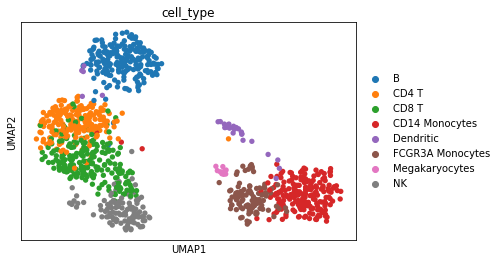

In [71]:
sc.pl.umap(train, color='cell_type')

In [72]:
sc.tl.ingest(val, train, obs=CELL_TYPE_KEY)
val.uns[f'{CELL_TYPE_KEY}_colors'] = train.uns[f'{CELL_TYPE_KEY}_colors']

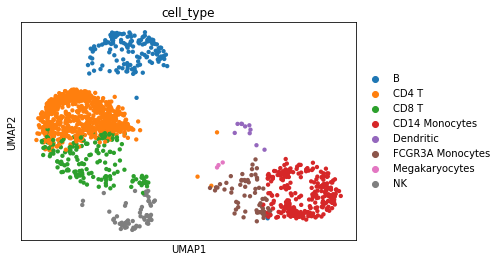

In [74]:
sc.pl.umap(val, color=[CELL_TYPE_KEY], wspace=0.5)
